# Music Genre Classification dengan Deep Learning


Tutorial ini akan menunjukkan bagaimana arsitektur Convolutional Neural Network digunakan untuk menyelesaikan pengenalan klasifikasi genre musik.

Dataset yang digunakan adalah gtzan (ada dalam folder data, download dan extrak). Dataset tersebut berisi kurang lebih 1000 track (potongan 30 detik lagu) dari 10 genre musik, setiap genrenya terdiri dari 100 sampel.

Data aslinya di-sample dengan frekuensi sampling 22050 Hz dalam format .au. Agar ukurannya lebih kecil, data dalam folder `data` diatas sudah dikompres ke dalam format .mp3, juga dalam frekuensi sampling 22050 Hz.

Tutorial ini terdiri atas:
* Loading dan preprocssing file audio
* Loading class file dari CSV dan menggunakan Label Encoder
* Menggunakan One-Hot Encoder untuk menyiapkan data class untuk Deep Learning
* Membangkitkan Mel spectrogram dari file audio
* Standarisasi data
* Memisahkan data train/test set
* Pemisahan stratified
* Convolutional Neural Networks: single, stacked, parallel
* ReLU activation
* Dropout
* Batch Normalization


Materi lanjutan:
* Majority Vote / Max Probability 
* Recurrent Neural Networks
* Cross-validation

Anda bisa mengeksekusi block demi blok kode di bawah ini dengan menekan SHIFT+ENTER

In [2]:
# General Imports

import os

# choosing between CPU and GPU
#device = 'cpu' # 'cpu' or 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation
from os.path import join

# Machine Learning Preprocessing and Evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import __version__ as sklearn_version

if sklearn_version.startswith('0.17'):
    from sklearn.cross_validation import train_test_split
    from sklearn.cross_validation import StratifiedShuffleSplit
else: # >= 0.18
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedShuffleSplit

# Deep Learning
# Pastikan setting keras di ~/.keras/keras.json menggunakan theano, "backend" = "theano"
 
from theano import config

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

# Plotting

import matplotlib.pyplot as plt
%matplotlib inline 

# Local imports
import rp_extract as rp
from audiofile_read import audiofile_read


Using Theano backend.


## Set path ke tempat Dataset

Arahkan variable `AUDIO_PATH` ke direktori dimana dataset disimpat, contohnya di ./data/gtzan_mp3


In [3]:
# SET PATH DATASET DISINI
AUDIO_PATH = './data/gtzan_mp3'

## Load Metadata

File `filelist_GTZAN_mp3_wclasses.txt` di dalam direktori dataset berisi metadata (genre) dalam format tab-separated value. File tersebut kita baca dengan perintah di bawah ini (dengan modul panda)

In [8]:
csv_file = join(AUDIO_PATH,'filelist_GTZAN_mp3_wclasses.txt')
metadata = pd.read_csv(csv_file, index_col=0, header=None)
metadata.head(10)

,1
0,
./rock/rock.00053.mp3,rock
./rock/rock.00051.mp3,rock
./rock/rock.00076.mp3,rock
./rock/rock.00084.mp3,rock
./rock/rock.00052.mp3,rock
./rock/rock.00057.mp3,rock
./rock/rock.00028.mp3,rock
./rock/rock.00035.mp3,rock
./rock/rock.00095.mp3,rock


In [9]:
# membuat list dari filename dengan genre yang berkesesuaian
filelist = metadata.index.tolist()
classes = metadata[1].values.tolist()

In [13]:
filelist, classes

(['./rock/rock.00053.mp3',
  './rock/rock.00051.mp3',
  './rock/rock.00076.mp3',
  './rock/rock.00084.mp3',
  './rock/rock.00052.mp3',
  './rock/rock.00057.mp3',
  './rock/rock.00028.mp3',
  './rock/rock.00035.mp3',
  './rock/rock.00095.mp3',
  './rock/rock.00088.mp3',
  './rock/rock.00048.mp3',
  './rock/rock.00009.mp3',
  './rock/rock.00036.mp3',
  './rock/rock.00032.mp3',
  './rock/rock.00019.mp3',
  './rock/rock.00042.mp3',
  './rock/rock.00003.mp3',
  './rock/rock.00061.mp3',
  './rock/rock.00013.mp3',
  './rock/rock.00038.mp3',
  './rock/rock.00054.mp3',
  './rock/rock.00014.mp3',
  './rock/rock.00004.mp3',
  './rock/rock.00091.mp3',
  './rock/rock.00025.mp3',
  './rock/rock.00086.mp3',
  './rock/rock.00090.mp3',
  './rock/rock.00046.mp3',
  './rock/rock.00075.mp3',
  './rock/rock.00026.mp3',
  './rock/rock.00049.mp3',
  './rock/rock.00093.mp3',
  './rock/rock.00001.mp3',
  './rock/rock.00099.mp3',
  './rock/rock.00010.mp3',
  './rock/rock.00081.mp3',
  './rock/rock.00089.mp3',
 

## Merubah label menjadi angka

Label dalam format string perlu dirubah dalam bentuk angka. Kita menggunakan LabelEncoder dari paket scikit-learn.

In [5]:
classes[0:5]

['rock', 'rock', 'rock', 'rock', 'rock']

In [6]:
classes[99:105]

['rock', 'hiphop', 'hiphop', 'hiphop', 'hiphop', 'hiphop']

In [14]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)

# Angka dari gener musik kita simpat dan tampilkan
n_classes = len(labelencoder.classes_)
print n_classes, "classes:", ", ".join(list(labelencoder.classes_))

classes_num = labelencoder.transform(classes)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock


Kemudian kita check sekarang hasil perubahan dari string menjadi angka tersebut.

In [15]:
classes_num[0:5]

array([9, 9, 9, 9, 9])

In [16]:
classes_num[99:105]

array([9, 4, 4, 4, 4, 4])

Catatan: Agar bisa me-retransform secara benar hasil prediksi genre musing kembali kedalam string, LabelEncoder kita simpat untuk kita pakai nanti.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# merubah vektor baris menjadi vektor kolom, seperi yang dibuthkan oleh OneHotEncoder, menggunakan reshape (-1,1)
classes_num_col = classes_num.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
classes_num_1hot = encoder.fit_transform(classes_num_col)
classes_num_1hot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
classes_num_1hot.shape

(1000, 10)

## Load File Audio

In [19]:
# membuat list daftar spektrogram untuk digunakan nanti
list_spectrograms = [] 

# parameter output yang diinginkan
n_mel_bands = 40   # y axis
frames = 80        # x axis

# parameter FFT
fft_window_size = 1024 #512
fft_overlap = 0.5
hop_size = int(fft_window_size*(1-fft_overlap))
segment_size = fft_window_size + (frames-1) * hop_size # ukuran segment yang diinginkan, frames

for filename in filelist:
    print ".", 
    filepath = os.path.join(AUDIO_PATH, filename)
    samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
    sample_length = wavedata.shape[0]

    # merubah menjadi mono (jika multiple channels / stereo)
    if wavedata.ndim > 1:
        wavedata = np.mean(wavedata, 1)
    
    # mencari segment audio (block)
    # hanya menghitung 1 segment audio (80 frame)
    # a) dari awal file     
    # pos = 0
    # b) dari tengah file
    pos = int(sample_length / 2 - segment_size / 2)
    wav_segment = wavedata[pos:pos+segment_size]
    
    # AUDIO PRE-PROCESSING

    # 1) FFT spectrogram 
    spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

    # 2) Transform ke perceptual Mel scale (menggunakan librosa.filters.mel)
    spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)
        
    # 3) Rubah ke dalam bentuk Log 10
    spectrogram = np.log10(spectrogram)
    
    list_spectrograms.append(spectrogram)
        
print "\nRead", len(filelist), "audio files"

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [20]:
print "Duration of input audio file:"
print sample_length / samplerate, "seconds"

Duration of input audio file:
30 seconds


In [21]:
print "An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long"

An audio segment is 1.88 seconds long


In [22]:
# Berapa banyak spectrogram yang kita dapatkan
len(list_spectrograms)

1000

In [23]:
# Bagaimana bentuk 1 spectrogram yang kita dapatkan, apakah 40 Mel bands dengan 80 frames
spectrogram.shape

(40, 80)

Catatan: Untuk penyederhanaan tutorial ini, kita hanya meload 1 segment dari ~1 detik di dalam file audio. 
Dalam real world setting, kita bisa membuat training instance dari sebanyak mungkin segment audio untuk diiskan dalam jaringan syarat tiruan.

In [24]:
spectrogram[0:5,0:5]

array([[-2.22468213, -2.16998997, -1.99815287, -2.15930204, -2.09368433],
       [-1.8034697 , -1.92510318, -1.78896157, -1.84884177, -1.75989478],
       [-2.04151898, -2.02549384, -2.07876139, -2.28285471, -2.21626449],
       [-2.24475796, -2.0991296 , -2.21757485, -2.15755237, -2.18409557],
       [-2.18591406, -2.664581  , -2.39105314, -2.4990512 , -3.22714398]])

In [36]:
# plot spectrogram
# plt.specgram(spectrogram[0], 22050, binsize=1024, ignore=True);
# plt.pcolormesh(, spectrogram[0])

## Membuat 1 array besar dari list spectrograms

In [37]:
# Sebuah list dari 40 x 80 spectrogram dibuat ke dalam satu array
# config.floatX adalah data type dari konfigurasi theano untuk tipe data float32 (dibutuhkan untuk kpomputasi GPU)
data = np.array(list_spectrograms, dtype=config.floatX)
data.shape

(1000, 40, 80)

In [38]:
# check Untuk nilai Inf (Infinity)

# np.log10(spectrogram) akan menghasilkan nilai inf jika nilai spectrogramnya 0, maka kita ganti dengan 0

if np.any(np.isinf(data)):
    print "Warning: Data contains inf values. Replacying by 0."
    data[np.isinf(data)] = 0

## Standardisasi

**Selalu normaliasi/standardisasi** data anda sebelum measukkankannya ke dalam jaringan syaraf tiruan (NN).

Kita menggunakan **attribute-wise standardization** yakni setiap fitur (pixel dalam spectrogram) dinormalisasikan secara invididu bukan menghitung nilai rata-rata dan standar deviasi dari semua nilai.

Selain 'attribute-wise', kita juga bisa menggunakan normalisasi 'flat' yakni menghitung nilai rata-rata dan standar deviasi dari semua pixel.

Salah satu tekniknya adalah dengan 'normalisasi max-min', yakni membatasi nilai bawah menjadi 0 dan nilai atas menjadi 1. 
Disini kita menggunakan normalisasi **zero-mean unit-variance** atau disebut juga Z-score normalization.

Dari scikit-learn, kita menggunakan `StandardScaler` untuk tujuan ini, yang akan menghasilkan normalisasi zero-mean unit-variance.

In [39]:
# Scaler dan normalzier bekerja pada vektor. Karenanya kita perlu mentransform matrix dari spectrogram
# ke dalam bentuk data vektor (vectorize atau reshape)

# vectorisasi
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(1000, 3200)

In [40]:
data[0:1].shape

(1, 3200)

In [42]:
# Normalisasi
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

Sekarang, semua nilai akan ditransformasikan menjadi variansi ruang 0-1.

In [43]:
np.mean(data, axis=0)

array([ 0.00000001, -0.00000003,  0.00000002,  0.00000001,  0.00000001,  0.00000003,  0.00000014,  0.00000002, -0.00000001, -0.00000001, ..., -0.00000003, -0.00000005,  0.00000005,  0.00000003,
        0.00000001,  0.        , -0.00000001,  0.00000003, -0.00000002,  0.00000001], dtype=float32)

In [44]:
np.std(data, axis=0)

array([0.99999994, 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , 1.        , ..., 1.        , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 0.99999994, 0.99999994, 1.0000001 , 1.0000002 ], dtype=float32)

In [45]:
# scaler menyimpan nilai asli untuk ditransformasikan lagi nanti,
# Sekarng kit tampilkan nilai rata-rata dan standar deviasi, dua vektor dengan panjang yang sama dengan data.shape[1]
scaler.mean_, scaler.scale_

(array([-0.00000016,  0.00000198, -0.00000071,  0.00000026,  0.00000031,  0.00000028, -0.00000196,  0.00000028, -0.00000096,  0.00000035, ..., -0.00000306,  0.00000075, -0.00000212,  0.00000144,
         0.00000044,  0.00000232, -0.00000006,  0.00000235,  0.0000038 , -0.00000178], dtype=float32),
 array([1.0000002 , 1.0000001 , 0.9999995 , 0.9999998 , 0.9999998 , 0.9999996 , 1.0000001 , 0.9999994 , 1.0000006 , 1.        , ..., 0.9999999 , 1.        , 1.0000001 , 0.9999997 , 0.9999996 ,
        1.0000002 , 1.0000001 , 0.9999998 , 1.0000006 , 0.99999917], dtype=float32))

# Membuat data Train dan Test

Salah satu best practice dari NN adalah memecah data menjadi dua bagian: Train Set (75%) dan Test Set (25%).

Disini kita bandingkan Radom splot dengan Stratified split:

In [46]:
# 25% dari data set digunakan untuk testing, sisanya untuk training
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

# RANDOM split dari data menjadi 2 bagian
# from sklearn.model_selection import train_test_split

train_set, test_set, train_classes, test_classes = train_test_split(data, classes_num, test_size=testset_size, random_state=0)

In [47]:
train_classes

array([3, 8, 9, 2, 9, 7, 8, 5, 2, 9, ..., 7, 9, 6, 7, 7, 0, 4, 8, 1, 8])

In [48]:
test_classes

array([2, 0, 3, 1, 8, 2, 9, 3, 6, 7, ..., 1, 5, 3, 6, 2, 5, 6, 9, 5, 8])

In [49]:
from collections import Counter
cnt = Counter(train_classes)

print "Number of files in each category in TRAIN set:"
for k in sorted(cnt.keys()):
    print k, ":", cnt[k]

Number of files in each category in TRAIN set:
0 : 80
1 : 74
2 : 70
3 : 70
4 : 84
5 : 72
6 : 74
7 : 74
8 : 73
9 : 79


Dalam random split, jumlah file per kelas (genre) bisa jadi tidak imbang/rata.
Pembagian yang lebih baik bisa dilakukan dengan menggunakan **stratified split**.

In [50]:
# Kelebihan stratified split: data dalam tiap kelas (genre) diambil sama
# from sklearn.model_selection import StratifiedShuffleSplit

if sklearn_version.startswith('0.17'):
    splits = StratifiedShuffleSplit(classes_num, n_iter=1, test_size=testset_size, random_state=0)
else: # >= 0.18:
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
    splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print "TRAIN INDEX:", train_index
    print "TEST INDEX:", test_index
    
    # split the data
    train_set = data[train_index]
    test_set = data[test_index]
    
    # and the numeric classes (groundtruth)
    train_classes = classes_num[train_index]
    train_classes_1hot = classes_num_1hot[train_index]  # 1 hot we need for traning
    test_classes = classes_num[test_index]
# Note: this for loop is only executed once, if n_splits==1

print train_set.shape
print test_set.shape
# Note: we will reshape the data later back to matrix form 

TRAIN INDEX: [349 816 960 261 665 517 653 438 170 472 ... 336 602 117  93 322 434 624  83 118  97]
TEST INDEX: [510 781 478 246 888 793 772 445 199 534 ... 967 490 486 683 984 390 858 372 982 499]
(750, 3200)
(250, 3200)


In [51]:
cnt = Counter(train_classes)
print "Number of files in each category in TRAIN set:"
for k in sorted(cnt.keys()):
    print k, ":", cnt[k]

Number of files in each category in TRAIN set:
0 : 75
1 : 75
2 : 75
3 : 75
4 : 75
5 : 75
6 : 75
7 : 75
8 : 75
9 : 75


Sekarang, jumlah file dalam tiap kategori/kelas (genre) berimbang.
Karena kita memiliki 100 data dalam setiap kategori, stratified split menjaga
agar distribusi tiap kategori sama dengan kategori lainnya, juga bila dataset sendiri tidak 
imbang antar kategori.

# Convolutional Neural Networks

Sebuah Convolutional Neural Network (CNN) adalah sebuah tipe (deep) Neural Network yang cocok untuk data 2D, seperti citra dan spectrogram, karena metode ini dioptimasi untuk belajar dari jarak spasial. Sebagai core elementnya adalah filter kernel 2D yang secara esensial mempelajari bobot dari NN dan menurunkan nilai costfunction dengan maxpooling.

Sebuah CNN bisa saja memiliki lebih dari satu lapis konvolusi, setiap lapisnya memiliki sejumlah N filter (yang mendefinisikan depth dari CNN layer), kemudian diikuti oleh pooling, yang mengambil pixel dari segolongan pixel-pixel yang berdekatan dan karenanya menurunkan resolusi citra dengan mengambil nilai maksimum dari pixel yang berdekatan tadi.

## Menyiapkan data
### Menambahkan kanal

Karena CNN pada awalnya digunakan untuk data citra (yang memiliki 3 kanal warna, RGB), kita perlu menambahkan dimensi untuk kanal warna pada data.

Pada spectrogram, warna tersebut bisa dianggap sebagai warna grayscale yang hanya punya 1 jenis warna saja. Jadi kita tambahkan satu dimensi untuk kanal warna pada data.

#### Theano vs. Tensorflow

Pada theano, secara tradisional kanal warna adalah dimensi pertama pada bentuk citra.
Pada tensorflow, kanal warna adalah dimensi terakhir dari bentuk citra.

Hal tersebut bisa dikonfigurasi pada file `~/.keras/keras.json`: "image_dim_ordering": "th" ATAU "tf" dimana "tf" (Tensorflow) merupakan default image ordering meskipun kita menggunakan Theano. 

Kita buat `if` statement untuk menyelesaikan permasalahan ini.

In [52]:
n_channels = 1 # 1 for grey-scale, 3 for RGB (in this case usually already present in the data)

if keras.backend.image_dim_ordering() == 'th':
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_set = train_set.reshape(train_set.shape[0], n_channels, ydim, xdim)
    test_set = test_set.reshape(test_set.shape[0], n_channels, ydim, xdim)
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_set = train_set.reshape(train_set.shape[0], ydim, xdim, n_channels)
    test_set = test_set.reshape(test_set.shape[0], ydim, xdim, n_channels)

In [53]:
keras.backend.image_dim_ordering()

'th'

In [54]:
train_set.shape

(750, 1, 40, 80)

In [55]:
test_set.shape

(250, 1, 40, 80)

In [57]:
# Kita simpan nilai dari bentuk citra yang baru dalam variabel `input_shape`
# Kemudian kita ambil semua nilainya kecual dimensi ke-0 (kanal warna)

input_shape = train_set.shape[1:]  
input_shape

(1, 40, 80)

# Membuat Model Neural Network di Keras

## Sequential Models

Pada Keras, kita bisa memilih antara model sekuensial atau model grafik. Model sekuensial adalah model standar, sedangkan model grafik digunakan untuk jaringan parallel.

## Membuat 1 Layer dan 2 Layer CNN

Cobalah untuk meng-comment/uncomment variabel berikut pada blok kode dibawah
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [58]:
np.random.seed(0) # make results repeatable

model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
#conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, 3, 3, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(Dropout(0.25)) 

# Layer 2
#model.add(Convolution2D(conv_filters, 3, 3))
#model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid')) 
#model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, for multi-class/multi-label problems use n output units 
# activation should be 'softmax' for multi-class / single-label output, 'sigmoid' for binary or multi-label tasks
model.add(Dense(n_classes,activation='softmax'))

Jika anda mendapati Overflow error: range node melebihi batas valid dari kotak di atas, check lagi urutan dimensi pada Theano vs Tensorflow pada blok kode sebelumnya, juga konfigurasi `keras.json` anda.

In [59]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 38, 78)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 19, 39)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 11856)         0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 200)           2371400     flatten_1[0][0]                  
___________________________________________________________________________________________

## Training CNN

In [60]:
# Mendefinisikan loss function 
loss = 'categorical_crossentropy' 

# Catatan: Untuk klasifikasi biner (2 kasus ) atau multi-class problem, gunakan:
#loss = 'binary_crossentropy' 

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [61]:
history = None

In [62]:
# TRAINING model

# ANDA bisa me-run blok kode ini beberapa kali

# jumlah epoch yang ingin dilakukan
epochs = 15

# Untuk training kita membutuhkan "1 hot encoded" kategori angka sebagai ground truth
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# kita simpan history dari accuracy training set
# kita tambahkan data ini ke dalam history sebelumnya jika kita me-run blok kode ini beberapa kali
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/15
750/750 [==============================] - 1s - loss: 2.1761 - acc: 0.1707     
Epoch 2/15
750/750 [==============================] - 1s - loss: 1.9776 - acc: 0.2960     
Epoch 3/15
750/750 [==============================] - 1s - loss: 1.8886 - acc: 0.3627     
Epoch 4/15
750/750 [==============================] - 1s - loss: 1.8106 - acc: 0.3907     
Epoch 5/15
750/750 [==============================] - 1s - loss: 1.7465 - acc: 0.4293     
Epoch 6/15
750/750 [==============================] - 1s - loss: 1.6875 - acc: 0.4653     
Epoch 7/15
750/750 [==============================] - 1s - loss: 1.6286 - acc: 0.4680     
Epoch 8/15
750/750 [==============================] - 1s - loss: 1.5864 - acc: 0.4867     
Epoch 9/15
750/750 [==============================] - 1s - loss: 1.5355 - acc: 0.5213     
Epoch 10/15
750/750 [==============================] - 1s - loss: 1.4961 - acc: 0.5040     
Epoch 11/15
750/750 [==============================] - 1s - loss: 1.4478 - acc: 0.5267   

In [63]:
def plot_traincurve(history):
    # definisikan 4 warna untu 4 nilai berbeda pada history
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

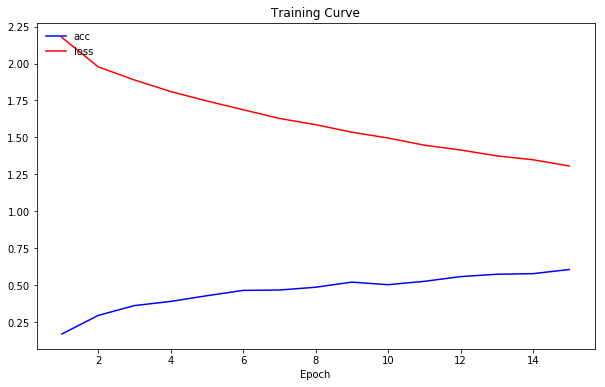

In [64]:
plot_traincurve(history)

#### Akurasi selalu naik ke atas pada data training, apakah hal ini juga berlaku pada data testing?

### Verifikasi Akurasi pada Test Set

In [66]:
test_pred = model.predict_classes(test_set)

250/250 [==============================] - 0s     


In [68]:
# prediksi
test_pred

array([1, 7, 0, 7, 2, 8, 7, 7, 4, 1, ..., 8, 5, 8, 6, 7, 6, 2, 0, 2, 7])

In [69]:
# groundtruth
test_classes

array([1, 7, 5, 3, 0, 7, 7, 5, 4, 1, ..., 2, 5, 5, 8, 2, 6, 0, 6, 2, 5])

In [70]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.436

In [71]:
# 2 layer
accuracy_score(test_classes, test_pred)

0.436

In [72]:
# 2 layer + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.436

In [73]:
# 2 layer + 32 convolution filters + ReLU + Dropout
accuracy_score(test_classes, test_pred)

0.436

## Custom Model

In [52]:
# Try to vary these parameters:

conv_filters = 16  # number of convolution filters (= CNN depth), e.g. 16 or 32

use_layers = 2    # 1 or 2

cnn_activation = 'relu' # sigmoid or relu


In [53]:
model = Sequential()

# Layer 1
#model.add(Convolution2D(conv_filters, 3, 3, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
#model.add(Convolution2D(conv_filters, 4, 12, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
model.add(Convolution2D(conv_filters, 10, 4, activation=cnn_activation, border_mode='valid', input_shape=input_shape))

if use_layers == 1:
    model.add(MaxPooling2D(pool_size=(1, 20))) 
    #model.add(MaxPooling2D(pool_size=(1, 5))) 
else:
    #model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(MaxPooling2D(pool_size=(1, 5))) 

# Layer 2
if use_layers == 2:
    model.add(Convolution2D(conv_filters, 3, 3, activation=cnn_activation, border_mode='valid', input_shape=input_shape))
    #model.add(BatchNormalization())
    #model.add(Activation(cnn_act)) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
model.add(Dropout(0.25))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, for multi-class/multi-label problems use n output units 
# activation should be 'softmax' for multi-class / single-label output, 'sigmoid' for binary or multi-label tasks
model.add(Dense(n_classes,activation='softmax'))

### Training

In [54]:
# Compiling the model

learn_rate = 0.05 # e.g. 0.02 or 0.05
optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [55]:
# TRAINING the model - (you may repeat execution of this cell to FURTHER train the model!)
epochs = 30
#History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# adding a validation set:
validation_percent = 0.1
History = model.fit(train_set, train_classes_1hot, validation_split=validation_percent, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
# we append this to previous history in case we execute this cell multiple times
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Train on 675 samples, validate on 75 samples
Epoch 1/30
675/675 [==============================] - 1s - loss: 2.3705 - acc: 0.1200 - val_loss: 2.4558 - val_acc: 0.1467
Epoch 2/30
675/675 [==============================] - 1s - loss: 2.2278 - acc: 0.1600 - val_loss: 2.4165 - val_acc: 0.1600
Epoch 3/30
675/675 [==============================] - 1s - loss: 2.0920 - acc: 0.2311 - val_loss: 2.5171 - val_acc: 0.1467
Epoch 4/30
675/675 [==============================] - 1s - loss: 2.0498 - acc: 0.2519 - val_loss: 2.1515 - val_acc: 0.1467
Epoch 5/30
675/675 [==============================] - 2s - loss: 1.9741 - acc: 0.2963 - val_loss: 2.1392 - val_acc: 0.2533
Epoch 6/30
675/675 [==============================] - 2s - loss: 1.9370 - acc: 0.2859 - val_loss: 2.4573 - val_acc: 0.1467
Epoch 7/30
675/675 [==============================] - 2s - loss: 1.8926 - acc: 0.3081 - val_loss: 1.9959 - val_acc: 0.2933
Epoch 8/30
675/675 [==============================] - 2s - loss: 1.8279 - acc: 0.3496 - val_lo

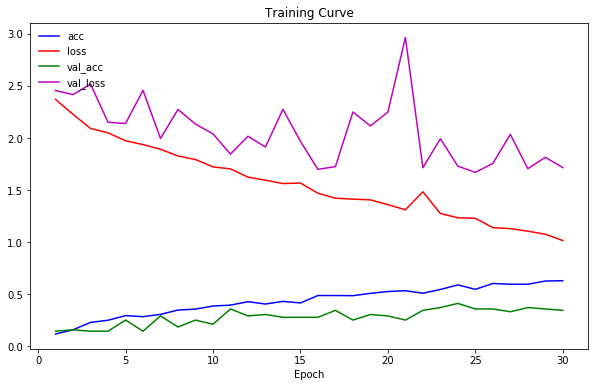

In [56]:
plot_traincurve(history)

### Testing

In [57]:
test_pred = model.predict_classes(test_set)

224/250 [=========================>....] - ETA: 0s

In [58]:
accuracy_score(test_classes, test_pred)

0.388

## Advanced Model: Additional Parameters & Techniques

Try:
* Adding Batch normalization
* Adding ReLU activation
* Adding Dropout

In [59]:
# Adapt parameters here:

conv_filters = 16   # number of convolution filters (= CNN depth), e.g. 16 or 32

batch_norm = True  # True or False

activation = 'relu' # sigmoid or relu

#dropout = None # None or 0 < dropout < 1
dropout = 0.25 # None or 0 < dropout < 1

In [60]:
model = Sequential()

# Layer 1
if batch_norm:
    model.add(BatchNormalization(input_shape=input_shape))
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(Convolution2D(conv_filters, 4, 12, border_mode='valid', input_shape=input_shape))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=(2, 2))) 
#model.add(MaxPooling2D(pool_size=(1, 20))) 
if dropout:
    model.add(Dropout(dropout))

# Layer 2
if batch_norm:
    model.add(BatchNormalization())
model.add(Convolution2D(conv_filters, 3, 3, border_mode='valid', input_shape=input_shape))
model.add(Activation(activation)) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
if dropout:
    model.add(Dropout(dropout))

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
model.add(Activation(activation))
if dropout:
    model.add(Dropout(dropout))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(n_classes,activation='softmax'))

### Training

In [61]:
# Compiling the model

optimizer = 'sgd'

#learn_rate = 0.02
#optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [62]:
# TRAINING the model - (you may repeat execution of this cell to FURTHER train the model!)
epochs = 30
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
# we append this to previous history in case we execute this cell multiple times
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/30
750/750 [==============================] - 2s - loss: 2.6416 - acc: 0.1427     
Epoch 2/30
750/750 [==============================] - 2s - loss: 2.2009 - acc: 0.2173     
Epoch 3/30
750/750 [==============================] - 2s - loss: 2.0626 - acc: 0.2560     
Epoch 4/30
750/750 [==============================] - 2s - loss: 1.9961 - acc: 0.3000     
Epoch 5/30
750/750 [==============================] - 2s - loss: 1.9090 - acc: 0.3200     
Epoch 6/30
750/750 [==============================] - 2s - loss: 1.8277 - acc: 0.3533     
Epoch 7/30
750/750 [==============================] - 2s - loss: 1.7626 - acc: 0.3920     
Epoch 8/30
750/750 [==============================] - 2s - loss: 1.7002 - acc: 0.3947     
Epoch 9/30
750/750 [==============================] - 2s - loss: 1.6566 - acc: 0.3973     
Epoch 10/30
750/750 [==============================] - 2s - loss: 1.5630 - acc: 0.4547     
Epoch 11/30
750/750 [==============================] - 2s - loss: 1.5530 - acc: 0.4573   

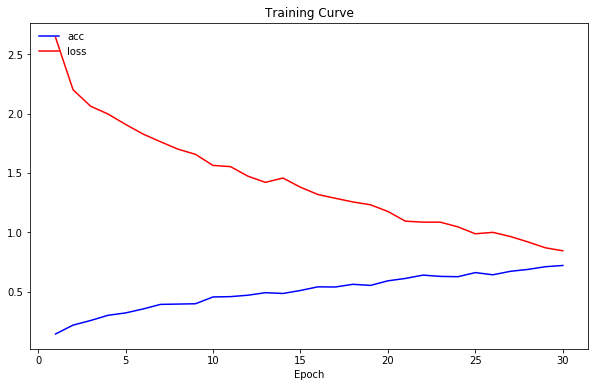

In [63]:
plot_traincurve(history)

### Testing

In [64]:
test_pred = model.predict_classes(test_set)

250/250 [==============================] - 0s     


In [65]:
accuracy_score(test_classes, test_pred)

0.504

In [66]:
print len(history['loss']), "epochs"

30 epochs


## Parallel CNNs

The motivation to use parallel CNNs is to use one CNN that detects patterns in the <b>frequencies</b> and another one that captures patterns in the <b>time domain, i.e. rhythm</b> in a combined way to learn better the structures in the sound.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.

In [67]:
n_filters = 16  # e.g. 16 or 32 
dropout = 0.25 # None or 0 < dropout < 1

In [68]:
# Input only specifies the input shape
input = Input(input_shape)

# CNN layers
# specify desired number of filters

# The functional API allows to specify the predecessor in (brackets) after the new Layer function call
conv_layer1 = Convolution2D(n_filters, 10, 4, activation='relu')(input)  # a vertical filter
conv_layer2 = Convolution2D(n_filters, 4, 10, activation='relu')(input)  # a horizontal filter

# Pooling layers - equal sized
#maxpool1 = MaxPooling2D(pool_size=(2,2))(conv_layer1)
#maxpool2 = MaxPooling2D(pool_size=(2,2))(conv_layer2)

# ALTERNATIVE: Pooling layers - complementary to vertical/horizontal filter
#maxpool1 = MaxPooling2D(pool_size=(1,2))(conv_layer1)
#maxpool2 = MaxPooling2D(pool_size=(2,1))(conv_layer2)

# LARGER Pooling layers - complementary to vertical/horizontal filter
maxpool1 = MaxPooling2D(pool_size=(1,5))(conv_layer1)
maxpool2 = MaxPooling2D(pool_size=(5,1))(conv_layer2) # used 4,1 first

# Dropout for both layers
if dropout:
    maxpool1 = Dropout(dropout)(maxpool1)
    maxpool2 = Dropout(dropout)(maxpool2)

# we have to flatten the Pooling output in order to be concatenated
poolflat1 = Flatten()(maxpool1)
poolflat2 = Flatten()(maxpool2)

# Merge the 2 parallel pipelines
merged = merge([poolflat1, poolflat2], mode='concat')

full = Dense(256, activation='sigmoid')(merged)
output_layer = Dense(n_classes, activation='softmax')(full)

# finally create the model
model = Model(input=input, output=output_layer)

In [69]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 40, 80, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 77, 16)    656         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 37, 71, 16)    656         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 31, 15, 16)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

### Training

In [70]:
# Compiling the model

learn_rate = 0.02
optimizer = SGD(lr=learn_rate) #, momentum=momentum) 

model.compile(loss='categorical_crossentropy' , optimizer=optimizer, metrics=['accuracy'])

history = None

In [71]:
# TRAINING the model (45 epochs, i.e. executing this block 3 times, worked well with this model)

epochs = 15
History = model.fit(train_set, train_classes_1hot, batch_size=32, nb_epoch=epochs)

# we keep the history of accuracies on training set
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Epoch 1/15
750/750 [==============================] - 4s - loss: 2.2133 - acc: 0.1880     
Epoch 2/15
750/750 [==============================] - 4s - loss: 2.0009 - acc: 0.2973     
Epoch 3/15
750/750 [==============================] - 4s - loss: 1.8976 - acc: 0.3413     
Epoch 4/15
750/750 [==============================] - 4s - loss: 1.8124 - acc: 0.3747     
Epoch 5/15
750/750 [==============================] - 4s - loss: 1.7314 - acc: 0.4040     
Epoch 6/15
750/750 [==============================] - 4s - loss: 1.6785 - acc: 0.4027     
Epoch 7/15
750/750 [==============================] - 4s - loss: 1.5806 - acc: 0.4707     
Epoch 8/15
750/750 [==============================] - 4s - loss: 1.5037 - acc: 0.5000     
Epoch 9/15
750/750 [==============================] - 4s - loss: 1.4404 - acc: 0.5413     
Epoch 10/15
750/750 [==============================] - 4s - loss: 1.3886 - acc: 0.5467     
Epoch 11/15
750/750 [==============================] - 4s - loss: 1.3250 - acc: 0.5680   

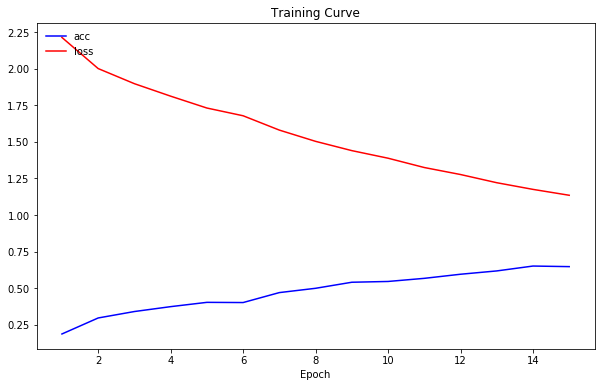

In [72]:
plot_traincurve(history)

### Testing

In [73]:
# THE GRAPH MODEL DOES NOT SUPPORT .predict_classes
# we use model.predict

test_pred = model.predict(test_set)

In [74]:
# it predicts the probabilities per class:
test_pred

array([[0.02001039, 0.87101144, 0.03031834, 0.00027662, 0.00007732, 0.06339845, 0.00136059, 0.00058199, 0.00469019, 0.00827467],
       [0.08880481, 0.06409609, 0.3754286 , 0.02305453, 0.00959318, 0.0763196 , 0.0118043 , 0.16691875, 0.0063219 , 0.17765827],
       [0.15937436, 0.00911601, 0.14656012, 0.0094245 , 0.00972962, 0.1551516 , 0.00289327, 0.01285084, 0.40935454, 0.08554515],
       [0.00885222, 0.00382352, 0.13534161, 0.10275047, 0.0184739 , 0.01724728, 0.00037607, 0.28909573, 0.30959076, 0.11444845],
       [0.15928166, 0.02297565, 0.354646  , 0.04224595, 0.0493791 , 0.07860359, 0.00238614, 0.04266209, 0.02020467, 0.22761518],
       [0.11102366, 0.02023238, 0.1488396 , 0.02323532, 0.00967795, 0.14106368, 0.00374236, 0.08485258, 0.32423833, 0.13309413],
       [0.02897973, 0.00108237, 0.07687055, 0.05198422, 0.04323603, 0.00542518, 0.00239733, 0.65015036, 0.05305935, 0.08681487],
       [0.04734444, 0.00573772, 0.16783029, 0.0231467 , 0.01806769, 0.02212676, 0.01420043, 0.583

In [75]:
# we get the predicted class from the maximum value in the probabilities, using argmax to get the class number
test_pred = np.argmax(test_pred, axis=1)
test_pred

array([1, 2, 8, 8, 2, 8, 7, 7, 8, 1, ..., 8, 5, 8, 6, 8, 6, 9, 2, 2, 9])

In [76]:
accuracy_score(test_classes, test_pred)

0.44